## Importing Dependencies

In [1]:
import tensorflow as tf
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"

## Import Libraries

In [4]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from glob import glob

## Visualization

In [5]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [01:53<00:00, 110.53it/s]


In [6]:
data.head(2)

,image,label
0,"[[[95, 69, 36], [97, 71, 38], [101, 75, 42], [...",R
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",R


In [7]:
data.shape

(22564, 2)

#### Total number of images in dataset

In [9]:
from collections import Counter
Counter(y_data)

Counter({'R': 9999, 'O': 12565})

#### Graphical breakdown of the 2 types of images

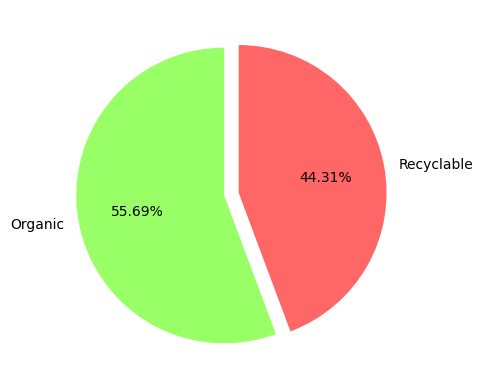

In [10]:
colors = ['#99ff66','#ff6666']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=1)
plt.show()

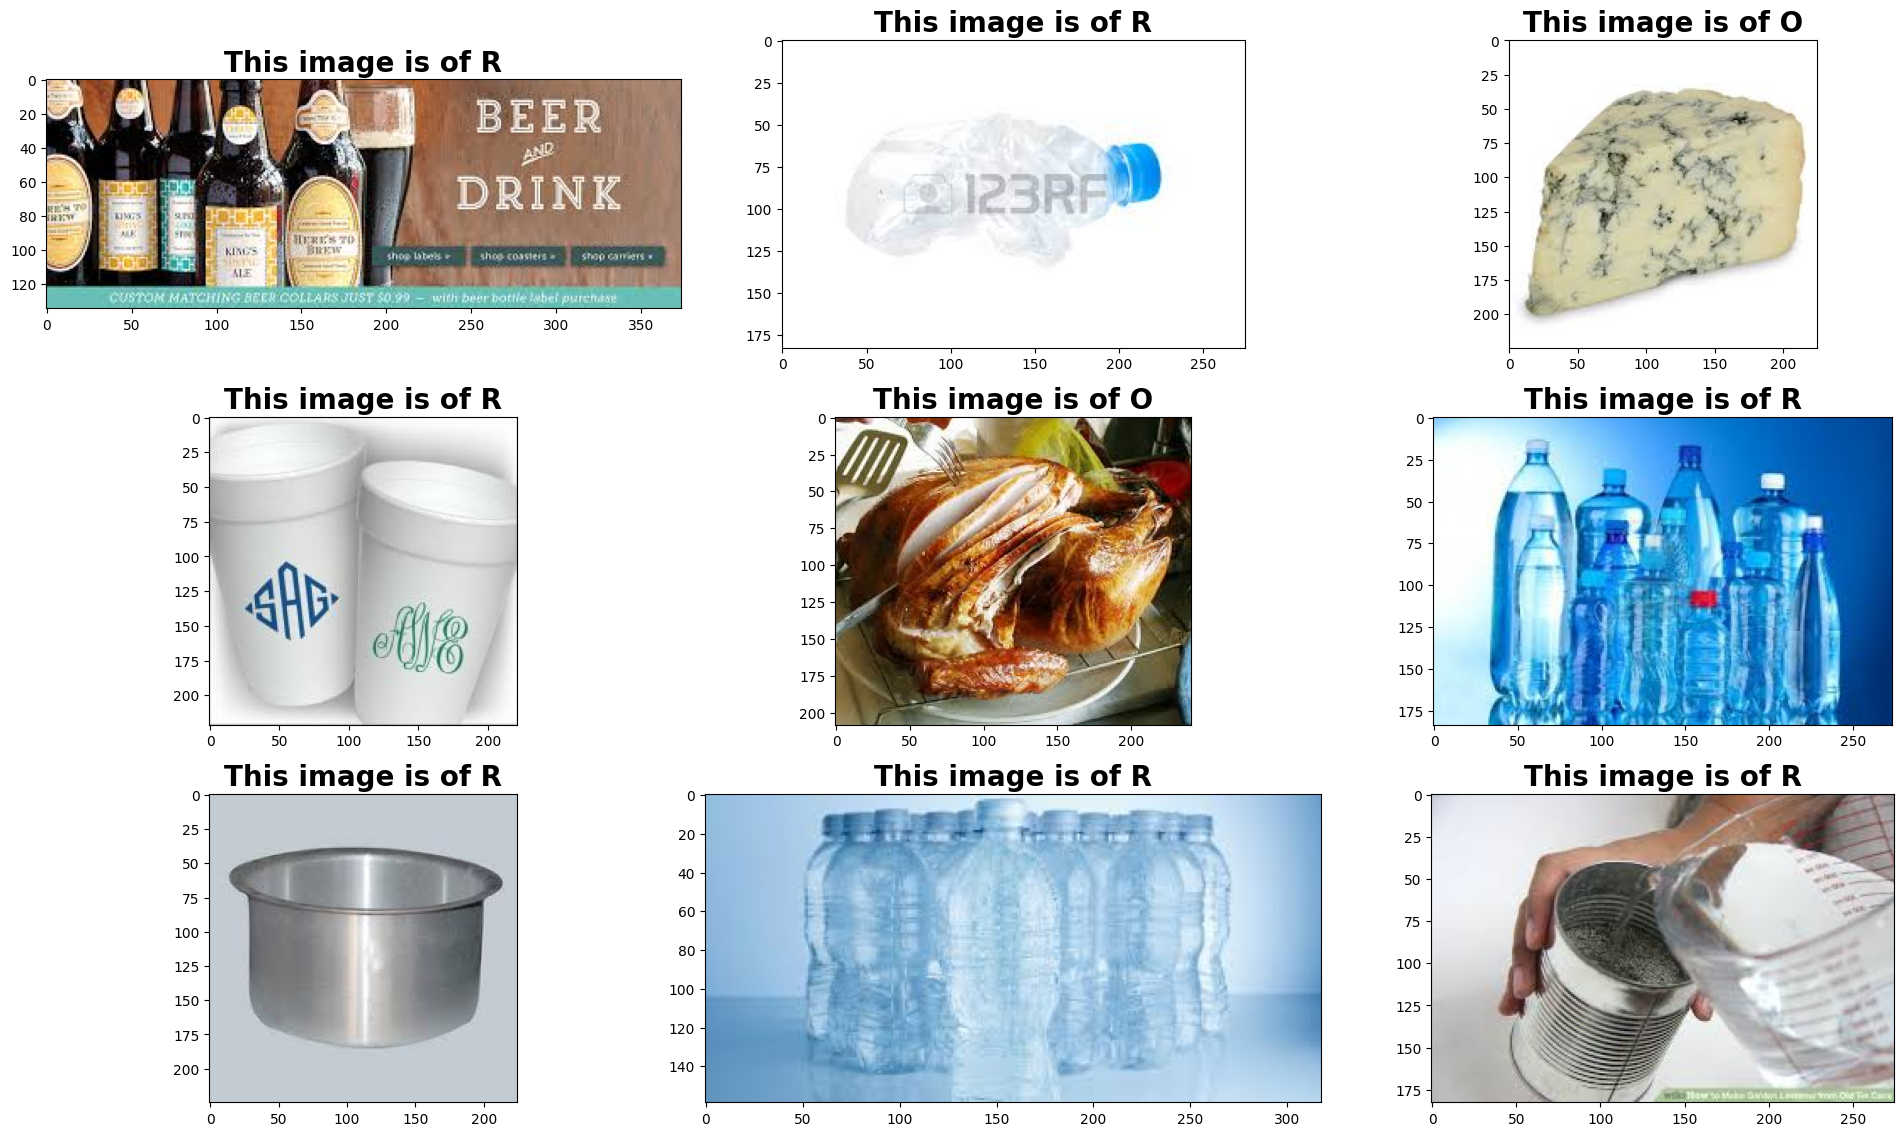

In [11]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

* O -> Organic
* R -> Recyclable

In [12]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


# Model Building

In [13]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

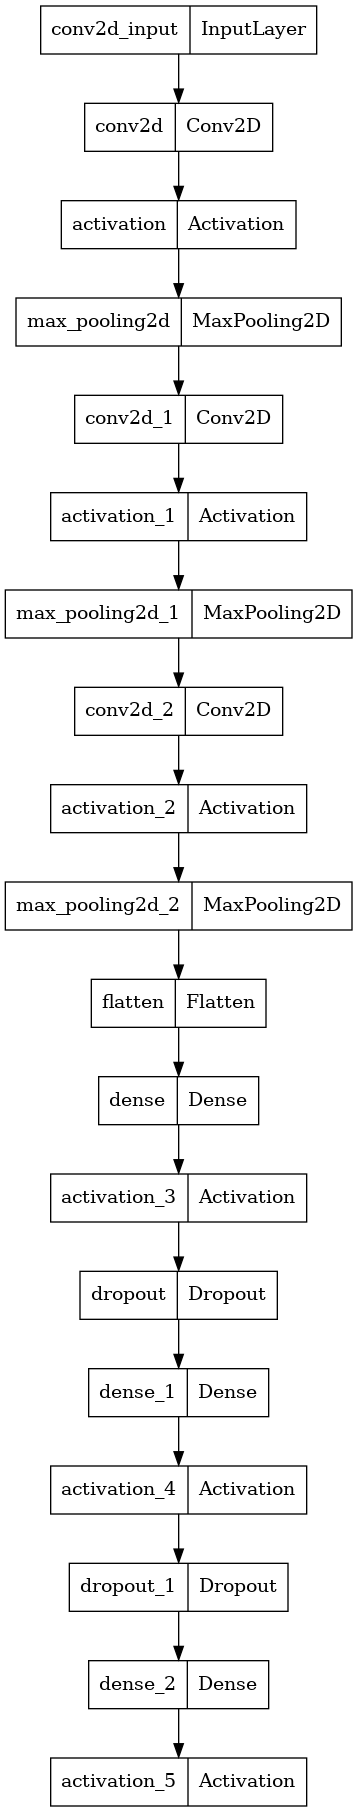

In [14]:
plot_model(model)

#### Normalizing the images

In [15]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [16]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


#### Training the model 

In [18]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=25,
        validation_data = test_generator)

Epoch 1/25
89/89 [==============================] - 92s 918ms/step - loss: 0.5424 - accuracy: 0.7657 - val_loss: 0.3716 - val_accuracy: 0.8715
Epoch 2/25
89/89 [==============================] - 69s 771ms/step - loss: 0.4063 - accuracy: 0.8348 - val_loss: 0.3111 - val_accuracy: 0.8866
Epoch 3/25
89/89 [==============================] - 67s 753ms/step - loss: 0.3689 - accuracy: 0.8514 - val_loss: 0.3216 - val_accuracy: 0.8711
Epoch 4/25
89/89 [==============================] - 67s 754ms/step - loss: 0.3437 - accuracy: 0.8616 - val_loss: 0.3230 - val_accuracy: 0.8703
Epoch 5/25
89/89 [==============================] - 67s 757ms/step - loss: 0.3150 - accuracy: 0.8766 - val_loss: 0.2966 - val_accuracy: 0.8830
Epoch 6/25
89/89 [==============================] - 67s 756ms/step - loss: 0.2896 - accuracy: 0.8851 - val_loss: 0.2874 - val_accuracy: 0.8894
Epoch 7/25
89/89 [==============================] - 68s 760ms/step - loss: 0.2709 - accuracy: 0.8933 - val_loss: 0.3488 - val_accuracy: 0.8591

### Graphical Representation of Results

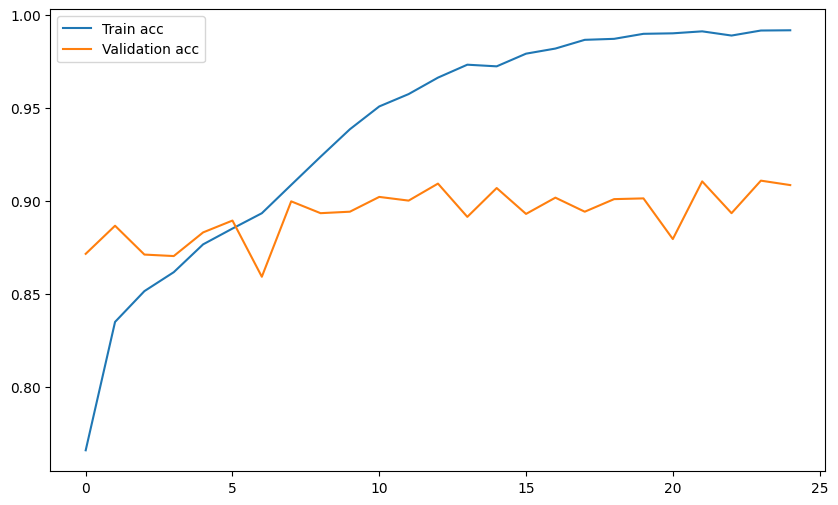

In [19]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

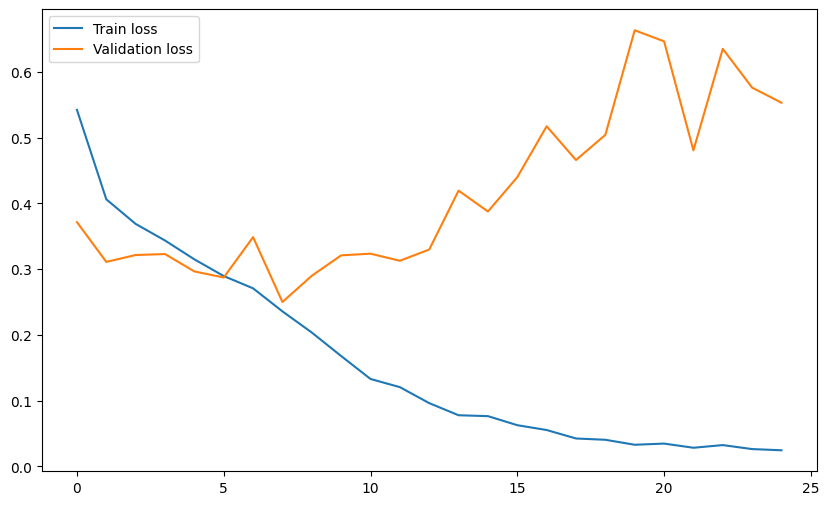

In [20]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

### Saving the Model for Prototype Building

In [21]:
model.save('wasteClassification.h5')

## Model Prediction

In [32]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 1: print("This image -> Recyclable")
    elif result == 0: print("This image -> Organic")